# Euclidean parametrization of RNA
### Written by Congzhou M Sha [(ORCID 0000-0001-5301-9459)](https://orcid.org/0000-0001-5301-9459)
### May 15, 2022

In [1]:
from IPython.display import display, HTML
display(HTML('''<div id="toc" style="max-height: 700px;"><ol class="toc-item"><li><a href="#Euclidean-parametrization-of-RNA">Euclidean parametrization of RNA</a></li><li><a href="#Preparation-of-data-from-the-Protein-Data-Bank-(PDB)">Preparation of data from the Protein Data Bank (PDB)</a></li><li><a href="#2.-Random-assortment-of-PDB-IDs-into-training-and-test-sets-(Optional)">2. Random assortment of PDB IDs into training and test sets (Optional)</a><ol class="toc-item"><li><a href="#Figure-3A:-Hierarchical-clustering-of-RNAs-by-primary-sequence">Figure 3A: Hierarchical clustering of RNAs by primary sequence</a></li></ol></li><li><a href="#3.-Prepare-neural-network-architecture">3. Prepare neural network architecture</a></li><li><a href="#Figure-3B-(Leave-one-out-validation)">Figure 3B (Leave-one-out validation)</a></li><li><a href="#Figure-2-(Violin-plot-performance)">Figure 2 (Violin plot performance)</a></li><li><a href="#Production-script">Production script</a></li></ol></div>'''))

A production-ready script is shown in the last section, requiring only the RNA sequence.

# Preparation of data from the Protein Data Bank (PDB)

We queried the Protein Data Bank for single RNAs such that:
1. Refinement resolution was less than 5 Å
2. Polymer Entity Type = RNA, and Polymer Entity Type was not DNA, Protein, NA-hybrid, or Other
3. Number of Distinct RNA Entities = 1

As of March 26, 2022, there were 788 RNA structures in the PDB (https://www.rcsb.org/) which satisfied this requirement.

We have provided a comma-delimited text file with the PDB IDs of the structures used for our paper: `RNA_lt5Angstrom.txt`

A total of 10 of the 788 structures were not able to be processed: `[1I7J,2JJA,2WNA,2XC6,310D,3P4A,468D,469D,470D,471D]`

The following section parses the RNA PDB files in `./structures` into an appropriate format for TensorFlow.

In [1]:
import numpy as np
import pickle, gzip, os


if not os.path.exists('data.pkl.gz'):
    with open('RNA_lt5Angstrom.txt') as f:
        l = f.read().split(',')
    
    data = {}
    
    for i in l:
        try:
            # Read PDB file and parse coordinates for all ATOM records
            with open(f'structures/{i}.pdb') as f:
                # The coordinates are contained in the subarrays as indexed below
                process = [(int(j[22:26]), j[17:20], j[21:22], np.array((float(j[31:38]), float(j[39:46]), float(j[47:54])))) 
                           for j in f.readlines() if j[:4] == 'ATOM']
            
            # Calculate centroids
            # Assign each atom to a residue
            residues = [j[:3] for j in process]
            residue2Atoms = {k: [] for k in residues}
            for index, j in enumerate(process):
                residue2Atoms[j[:3]].append(index)
            
            # Get the primary sequence of the RNA
            seq = [i[1].strip() for i in residue2Atoms]
            # Get coordinates for each atom
            coords = np.stack([i[-1] for i in process], axis=0).astype(np.float32)
            # Find the centroid of each residue
            residueCentroids = np.stack([np.mean(coords[residue2Atoms[k], :], axis=0) for k in residue2Atoms], axis=0)
            distMat = np.linalg.norm(residueCentroids[None, ...] - residueCentroids[:, None, :], axis=-1)
            data[i] = seq, distMat
        except:
            print(i) # [1I7J,2JJA,2WNA,2XC6,310D,3P4A,468D,469D,470D,471D] not processed
            continue
    
    residueTypes = ['A', 'C', 'DA', 'DG', 'DU', 'G', 'I', 'N', 'U']
    # Perform one-hot encoding of the residues
    oneHot = lambda x: [x == i for i in residueTypes]
    for (k, (i, j)) in data.items():
        seq = np.array([oneHot(m) for m in i])        
        data[k] = (seq, j)
    
    # Save intermediate data file
    with gzip.open('data.pkl.gz', 'wb') as f:
        pickle.dump(data, f)
else:
    with gzip.open('data.pkl.gz', 'rb') as f:
        data = pickle.load(f)

# Save sequences for later use
arr2Seq = lambda x: ''.join([str(np.where(i)[0][0]) for i in x])
sequences = {k: v[0] for (k, v) in data.items()}
seqs = {k: arr2Seq(v) for (k,v) in sequences.items()}

# Extra pre-processing for tensors, performing the Kronecker product as described in the manuscript.
# N is the length of a particular RNA and C is the number of channels in residueTypes (9)
for (k, (X, Y)) in data.items():
    # Kronecker product
    seq = X[None, None, ..., None] # [BATCH, 1, N, C, 1]
    seq = seq * np.transpose(seq, axes=[0, 2, 1, 4, 3])
    # Flatten last two dimensions
    mat = np.reshape(seq, (1, seq.shape[1], seq.shape[1], -1)) # [BATCH, N, N, C^2]
    data[k] = mat.astype(np.float32), Y[None, ...]


# 2. Random assortment of PDB IDs into training and test sets (Optional)

We randomly split our data set in a 60:40 ratio. These cells only need to be run when reproducing the paper.

In [2]:
if not os.path.exists('dataSplit.pkl'):
    import random
    entries = list(data.keys())
    random.shuffle(entries)
    n = len(entries)
    # 60:40 split
    split = entries[:6 * n // 10], entries[6 * n // 10:]
    with open('dataSplit.pkl', 'wb') as f:
        pickle.dump(split, f)
else:
    with open('dataSplit.pkl', 'rb') as f:
        (training, test) = pickle.load(f)

We also performed hierarchical clustering on primary sequences to decorrelate training and test sets. Install `python-Levenshtein` for this clustering.

In [3]:
!pip install python-Levenshtein

## Figure 3A: Hierarchical clustering of RNAs by primary sequence

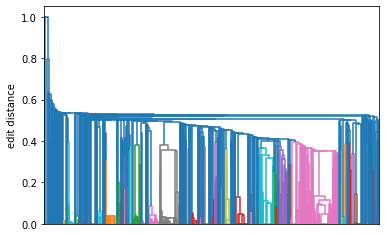

In [4]:
from Levenshtein import distance as ldist
import matplotlib.pyplot as plt

# Calculate all pairwise Levenshtein distances
editDist = {(i,j): min(1, ldist(s1, s2) / min(len(s1), len(s2))) for (index1, (i, s1)) in enumerate(seqs.items()) for (index2, (j, s2)) in enumerate(seqs.items()) if index1 > index2}

# Hierarchically cluster 
from scipy.cluster.hierarchy import dendrogram, linkage
keys = [sorted(k) for k in editDist.keys()]
values = editDist.values()
sorted_keys, distances = zip(*sorted(zip(keys, values)))
Z = linkage(distances)
labels = sorted(set([key[0] for key in sorted_keys] + [sorted_keys[-1][-1]]))
d = dendrogram(Z, labels=['' for i in labels], color_threshold=0.4)
plt.ylabel('edit distance')
plt.savefig('editDist.svg')

colors = np.array(d['leaves_color_list'])
colorSet = list(set(colors))
counts = [np.sum(colors == i) for i in colorSet]
leaveOut = colors[np.argmax(counts)]
rest = [labels[j] for j in range(len(colors)) if colors[j] != leaveOut]
leaveOut = list(set(labels) - set(rest))

# 3. Prepare neural network architecture

We implement the architecture shown in Figure 1.

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, SpatialDropout2D as Dropout2D, LayerNormalization as LN
from tensorflow.nn import leaky_relu as LR

BATCH = 1

# From EDMNets
class Softplusmh(tf.keras.layers.Layer):
    """
    Matrix softplus function for symmetric input matrices. The resulting matrix is symmetric positive definite.
    """

    def call(self, inputs, **kw):
        eigenvalues, eigenvectors = tf.linalg.eigh(inputs)
        sp_ev = tf.math.softplus(eigenvalues)
        sp_ev_D = tf.linalg.diag(sp_ev)
        eigenvectors_T = tf.linalg.matrix_transpose(eigenvectors)
        spA = eigenvectors @ sp_ev_D @ eigenvectors_T
        return spA, eigenvalues, sp_ev

class L2M(tf.keras.layers.Layer):
    """
    Converts an L matrix (shape n-1 x n-1) to an M matrix (shape n x n) by padding the first column and row with zeros.
    """

    def call(self, inputs, **kw):
        return tf.pad(inputs, [[0, 0], [1, 0], [1, 0]])


class M2D(tf.keras.layers.Layer):
    """
    Converts a Gram matrix `M` to an EDM `D`.
    """

    def call(self, inputs, **kwargs):
        M = inputs
        M_diag = tf.linalg.diag_part(M)
        return tf.expand_dims(M_diag, 1) + tf.expand_dims(M_diag, 2) - 2. * M

# The implementation of Figure 1
class epRNA(tf.keras.Model):
    def __init__(self, hidden_dim=128, kernel_size=3, n_hidden=8, n_EDM=4):
        super(epRNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.reduction = Dense(hidden_dim, kernel_regularizer='l2')
        self.hidden = [(Conv2D(filters=hidden_dim, kernel_size=kernel_size, padding='same', kernel_regularizer='l2')) for i in range(n_hidden)]
        self.LNs = [LN() for i in range(n_hidden)]
        self.toEDM = [(Dense(hidden_dim, kernel_regularizer='l2')) for i in range(n_EDM)]
        self.LNs2 = [LN() for i in range(n_EDM)]
        self.last = Dense(1)
        self.SP = Softplusmh()
        self.l2m = L2M()
        self.m2d = M2D()
    
    # Implement the forward pass of the network
    # Input [BATCH, N, N, C^2]
    def call(self, mat):        
        # Reduce sparsity
        mat = self.reduction(mat) # [BATCH, N, N, hidden_dim]
        mat = LR(mat) # [BATCH, N, N, hidden_dim]
        
        # Convolutions, dimensions remain the same
        prev = mat
        for i, (layer, ln) in enumerate(zip(self.hidden, self.LNs)):
            # Layer normalization
            mat = ln(mat)
            # Hidden layer
            mat = layer(mat)
            # Activation
            mat = LR(mat)
            # Dropout
            mat = Dropout2D(rate=0.2)(mat)
            # Residual connection
            if i % 3 == 1:
                mat = mat + prev
                prev = mat
        
        # Processing to EDM input
        for i, (layer, ln) in enumerate(zip(self.toEDM, self.LNs2)):
            mat = ln(mat)
            mat = layer(mat)
            mat = LR(mat)
            mat = Dropout(rate=0.2)(mat)
        # Residual connection
        mat = mat + prev # [BATCH, N, N, hidden_dim]
        mat = self.last(mat) # [BATCH, N, N, 1]
        mat = tf.squeeze(mat, axis=-1) # [BATCH, N, N]
        mat = 0.25 * (mat[..., :-1, :-1] + mat[..., 1:, :-1] + mat[..., :-1, 1:] + mat[..., 1:, 1:]) # [BATCH, N-1, N-1]
        
        # Algorithm 1 from Hoffmann and Noé
        L = 0.5 * (mat + tf.linalg.matrix_transpose(mat)) # [BATCH, N-1, N-1]
        L, _, ev_L = self.SP(L) # [BATCH, N, N]
        M = self.l2m(L) # Gram matrix
        D = self.m2d(M) # Euclidean distance matrix [BATCH, N, N]
        return D, M

def edm_loss(D, J):
    """
    Loss imposing a soft constraint on EDMness for the input matrix `D`.
    :param D: a hollow symmetric matrix
    :param n_atoms: number of atoms
    :return: loss value
    """
    # D is EDM iff T = -0.5 JDJ is positive semi-definite
    T = -0.5 * tf.matmul(tf.matmul(J, D), J)
    J_ev = tf.linalg.eigvalsh(T)
    return tf.reduce_sum(tf.square(tf.nn.relu(-J_ev)), axis=-1)

def rank_penalty(M, target_rank):
    eigenvalues, _ = tf.linalg.eigh(M)
    n_eigenvalues = tf.shape(eigenvalues)[1]
    undesired_evs, _ = tf.math.top_k(-eigenvalues, k=n_eigenvalues - target_rank, sorted=False,
                                     name="undesired_evs")
    undesired_evs = tf.square(undesired_evs)
    return tf.reduce_sum(undesired_evs, axis=-1)

DIM = 3

shapes = set(i.shape[1] for (_, i) in data.values())

# Save centering matrices (C in the manuscript) to prevent repetitive allocation during forward calls
Js = {}
for n_atoms in shapes:
    eye = tf.eye(num_rows=n_atoms)
    J = eye - tf.ones(shape=(n_atoms, n_atoms)) / n_atoms
    J = tf.reshape(J, shape=(-1, n_atoms, n_atoms))
    J = J[None, :, :]
    Js[n_atoms] = J

# Loss to get 3D and EDM
@tf.function
def ELoss(D, M, J):
    loss_edm = edm_loss(D, J)
    # want embedding dimension 2
    loss_rank = rank_penalty(M, target_rank=DIM)
    # loss is just the sum of the two
    loss = loss_edm + loss_rank
    return loss

In [ ]:
# Which trained model would you like to load?
weightChoice = 'leave-one-out'

model = epRNA()
weightDict = {'uniform': 'E128', 'leave-one-out': 'E128LO', 'short': 'E128Short', 'long': 'E128Long'}

WC = weightDict[weightChoice]

if os.path.exists(f'trained_models/{WC}/EDRNA.data-00000-of-00001'):
    model.load_weights(f'trained_models/{WC}/EDRNA')
    print(f'Model "{weightChoice}" loaded!')
else:
    print(f'Failed to load model "{weightChoice}"!')

In [27]:
# Comment out the next line if the computations are having issues
@tf.function(experimental_relax_shapes=True)
def train_step(model, X, Y, J, optimizer):
    # Training loop
    with tf.GradientTape() as t:
        D, M = model(X)
        # ELoss gives E_{edm} and E_{rank}; the second loss is the L^2 norm of the distance matrices
        losses = ELoss(D, M, J), tf.square(Y - D)
        grad = t.gradient(losses, model.trainable_variables)
    # Apply gradient clipping to regularize training
    grad, _ = tf.clip_by_global_norm(grad, 5.0)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    # Return some of the losses for tracking purposes
    return losses[0], tf.reduce_sum(losses[-1])

import sys
from random import shuffle
# Main training loop
def train(start, stop, training=training, data=data, model=epRNA(), Js=Js):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    training = [data[i] for i in training if data[i][1].shape[1] > 6 and data[i][1].shape[1] < 100]
    for epoch in range(start, stop):
        # Keep track of losses
        l1s, l2s = [], []
        
        # Shuffle the training data at the beginning of each training epoch
        shuffle(training)
        for i, (X, Y) in enumerate(training):
            J = Js[Y.shape[1]]
            l1, l2 = train_step(model, X, Y, J, optimizer)
            l1s.append(l1.numpy().flatten()[0]), l2s.append(l2.numpy())
            print(l1s[-1], l2s[-1])
        print(f'Epoch {epoch}', np.mean(l1s), np.mean(l2s))
        sys.stdout.flush()
        if epoch % 100 == 0:
            model.save_weights('tutorialTrained/EDRNA')
            if epoch % 1000 == 0:
                model.save_weights(f'tutorialTrained/EDRNA{epoch}')
                
# Leave-one-out training shown here
train(0, 1, model=model, training=rest)

2022-05-15 18:01:27.591265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33.63646 1551.9193


2022-05-15 18:01:29.167837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


46.916718 595541.3


2022-05-15 18:01:31.032229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25.804512 1046389.1
35.676453 442266.8
56.798393 4022.5547
58.090244 167198.08
78.20032 1537.869
67.68102 595.5489
56.64262 13931.14
5999.4834 4465.2163
18666036.0 26447.594
1023050.0 24762.309
136.71794 2555.3198
99.28915 792.8358
98.84926 787.25854
58.393265 1525871.5
261.48196 12156.948
90.07408 10208.094
96.22538 645.286
4092150.0 18721.822
43.285263 597757.06
174.44594 29273.34
16368540.0 19277.113
1116359.2 54573.895
3892572.5 36420.094
90.61159 13084.263
213.20522 20691.5
79.63962 1665.2865
28.08081 142070.14
151.60046 2453.9883
77.06998 119619.3
763.6384 16563.16
60.92314 2596.334
1553827.0 83616.945
6215233.5 31726.738
131.8981 44243.297
101.013954 675.2096
60683816.0 25868.611
89.70828 20731.992
62.272625 3168.2456
4.424119 5651330.0
103.36917 5448.6094
24860860.0 51434.305
102.45948 3645.164
61.16532 2715.8408
5.567852 837.37836
242735170.0 23819.914
88.190125 1663.1196
140513.25 18140.775
302.2876 98588.305
40.534035 455.62338
62.5744 1361.7188
101.68001 541.7352


KeyboardInterrupt: 

 We may convert Euclidean distance matrices to coordinates using multi-dimensional scaling.

In [29]:
# Classical multi-dimensional scaling
def MDS(D):
    n = tf.shape(D)[-1]
    C = tf.eye(n) - 0.5 / tf.cast(n, tf.float32) * tf.ones_like(D)
    B = -0.5 * C @ tf.square(D) @ C
    # Distance matrix is symmetric, so we may use eigh
    # Note: Eigenvalues must be distinct, or else eigh is not numerically stable.
    e, v = tf.linalg.eigh(B)
    # Take the first 3 eigenvalues (already sorted largest to smallest)
    e = tf.sqrt(e[..., None, -1:-4:-1])
    # And eigenvectors
    v = v[..., -1:-4:-1]
    # Return coordinates
    return e * v

As an example of classical multi-dimensional scaling in action, we are able to invert the distance matrix computed for PDB ID [7SAM](https://www.rcsb.org/structure/7SAM)
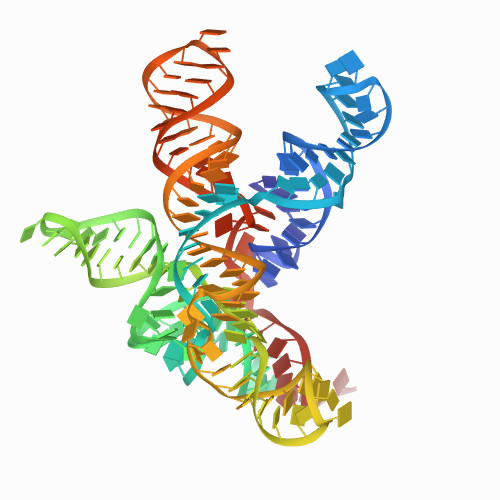

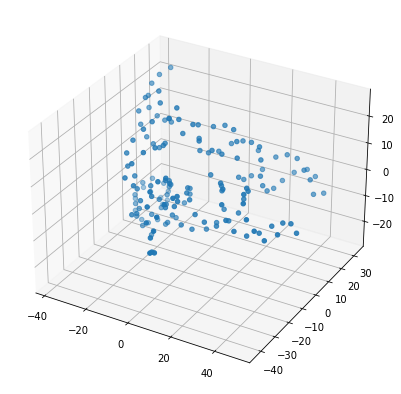

In [30]:
# As an example of MDS in action
A = tf.convert_to_tensor(data['7SAM'][-1])
D = A[0]
coords = MDS(D)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(*coords.numpy().T)

We implement the [Kabsch algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm) to take advantage of TensorFlow's speed.

In [31]:
# The well-known Kabsch algorithm
def kabsch(A, B, axis=0):
    # Center the two sets of coordinates
    a_mean = tf.reduce_mean(A, axis=axis, keepdims=True)
    b_mean = tf.reduce_mean(B, axis=axis, keepdims=True)
    A_c = A - a_mean
    B_c = B - b_mean
    # Covariance matrix
    H = tf.transpose(A_c) @ B_c
    # Singular value decomposition
    S, U, V = tf.linalg.svd(H)
    # Rotation matrix
    R = V @ tf.transpose(U)
    # Rotation matrix with parity
    Rp = V @ np.diag([1, 1, -1]) @ tf.transpose(U)
    # Align the matrices
    A_aligned = tf.transpose(R @ tf.transpose(A_c))
    A_alignedp = tf.transpose(Rp @ tf.transpose(A_c))
    # RMSD calculation
    rmsd = tf.sqrt(tf.reduce_sum((A_aligned - B_c) ** 2) / A.shape[0])
    # RMSD calculation with parity
    rmsdp = tf.sqrt(tf.reduce_sum((A_alignedp - B_c) ** 2) / A.shape[0])
    # Return the lower of the two
    if rmsd < rmsdp:
        return R, rmsd, A_aligned
    else:
        return Rp, rmsdp, A_alignedp

In [37]:
# Compute on validation set
def validate(model=model, validation=[]):
    val = [data[i] for i in validation if data[i][1].shape[1] < 600]
    rmsds = {}
    for i, ((X, Y), PDBID) in enumerate(zip(val, validation)):
        J = Js[Y.shape[1]]
        outputD, _ = model(X, training=False)
        coordsOut = MDS(outputD[0])
        coordsOrig = MDS(Y[0])
        _, rmsd, A_aligned = kabsch(coordsOut, coordsOrig)
        rmsds[PDBID] = (rmsd.numpy(), coordsOrig, coordsOut, A_aligned, outputD)
        print(i, rmsd)
    return rmsds
# Leave-one-out validation set by default
v = [i for i in leaveOut if data[i][1].shape[1] > 6]
rmsds = validate(validation=v)

0 tf.Tensor(1.7913586, shape=(), dtype=float32)
1 tf.Tensor(35.22184, shape=(), dtype=float32)
2 tf.Tensor(27.529692, shape=(), dtype=float32)
3 tf.Tensor(15.705089, shape=(), dtype=float32)
4 tf.Tensor(4.4122014, shape=(), dtype=float32)
5 tf.Tensor(1.9972211, shape=(), dtype=float32)
6 tf.Tensor(4.3896875, shape=(), dtype=float32)
7 tf.Tensor(2.82328, shape=(), dtype=float32)
8 tf.Tensor(29.921988, shape=(), dtype=float32)
9 tf.Tensor(4.6025686, shape=(), dtype=float32)
10 tf.Tensor(1.4917871, shape=(), dtype=float32)
11 tf.Tensor(32.364582, shape=(), dtype=float32)
12 tf.Tensor(5.1691356, shape=(), dtype=float32)
13 tf.Tensor(3.3213978, shape=(), dtype=float32)
14 tf.Tensor(27.424747, shape=(), dtype=float32)
15 tf.Tensor(6.3296556, shape=(), dtype=float32)
16 tf.Tensor(17.638855, shape=(), dtype=float32)
17 tf.Tensor(35.346733, shape=(), dtype=float32)
18 tf.Tensor(16.166998, shape=(), dtype=float32)
19 tf.Tensor(2.8046935, shape=(), dtype=float32)
20 tf.Tensor(7.416418, shape=(), 

# Figure 3B (Leave-one-out validation)
Note: 3C and 3D are processed similarly, and we omit them here. We used [seaborn](https://seaborn.pydata.org/) to create these plots. The results may not precisely match the manuscript due to retrained weights, however they are qualitatively similar.

In [ ]:
!pip install seaborn

/Users/mikesha/miniforge3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


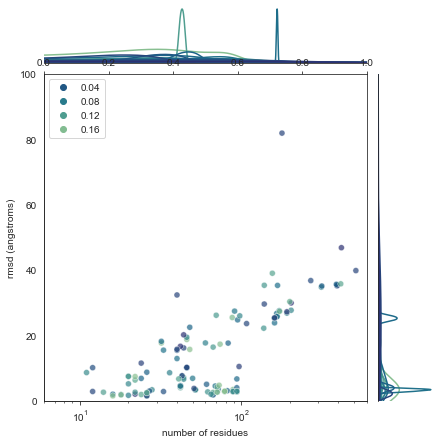

In [42]:
arr2Seq = lambda x: ''.join([str(np.where(i)[0][0]) for i in x])
seqs = {k: arr2Seq(v) for (k,v) in sequences.items()}
editDist = {(i,j): ldist(s1, s2) / min(len(s1), len(s2)) for (i, s1) in seqs.items() for (j, s2) in seqs.items() if i != j}

import seaborn as sns
from matplotlib import scale
percentiles = 5
inTraining = np.array([np.sum([editDist[k, j] < 0.6 for j in rest]) / len(rest) for (k, i) in rmsds.items() if i[0] < 100])

sns.set_style('white')
g = sns.jointplot([i[-2].shape[0] for i in rmsds.values() if i[0] < 100], \
                  (np.array([i[0] for i in rmsds.values() if i[0] < 100])),\
                     hue=inTraining, palette='crest_r', height=6, alpha=0.7 , marginal_kws={'fill': False})
g.ax_joint.set_xlabel('number of residues')
g.ax_joint.set_ylabel('rmsd (angstroms)')
g.ax_joint.set_xlim(6, 600)
g.ax_joint.set_ylim(0, 100)
ax1=g.ax_joint
ax2=g.ax_joint.twiny()
ax1.set(xscale=scale.LogScale(ax1, base=10.0))
sns.move_legend(g.ax_joint, "upper left")
plt.savefig('leaveOut.svg')

# Figure 2 (Violin plot performance)
Violin plot of RMSDs for uniform split (60:40). Reload model and perform inference on validation set.

In [43]:
WC = weightDict['uniform']
model = epRNA()
model.load_weights(f'trained_models/{WC}/EDRNA')

In [44]:
rmsdsTest = validate(validation=test)

0 tf.Tensor(17.86822, shape=(), dtype=float32)
1 tf.Tensor(7.099157, shape=(), dtype=float32)
2 tf.Tensor(37.367428, shape=(), dtype=float32)
3 tf.Tensor(21.101357, shape=(), dtype=float32)
4 tf.Tensor(7.1954513, shape=(), dtype=float32)
5 tf.Tensor(19.105963, shape=(), dtype=float32)
6 tf.Tensor(16.929941, shape=(), dtype=float32)
7 tf.Tensor(7.298852, shape=(), dtype=float32)
8 tf.Tensor(3.367886, shape=(), dtype=float32)
9 tf.Tensor(20.165796, shape=(), dtype=float32)
10 tf.Tensor(1.6643258, shape=(), dtype=float32)
11 tf.Tensor(27.624868, shape=(), dtype=float32)
12 tf.Tensor(12.987172, shape=(), dtype=float32)
13 tf.Tensor(2.111988, shape=(), dtype=float32)
14 tf.Tensor(11.878434, shape=(), dtype=float32)
15 tf.Tensor(12.472171, shape=(), dtype=float32)
16 tf.Tensor(22.634295, shape=(), dtype=float32)
17 tf.Tensor(20.414198, shape=(), dtype=float32)
18 tf.Tensor(12.834971, shape=(), dtype=float32)
19 tf.Tensor(2.1992297, shape=(), dtype=float32)
20 tf.Tensor(2.8243575, shape=(), d

168 tf.Tensor(18.185688, shape=(), dtype=float32)
169 tf.Tensor(29.214685, shape=(), dtype=float32)
170 tf.Tensor(3.4586723, shape=(), dtype=float32)
171 tf.Tensor(4.6025686, shape=(), dtype=float32)
172 tf.Tensor(3.3575, shape=(), dtype=float32)
173 tf.Tensor(17.588015, shape=(), dtype=float32)
174 tf.Tensor(22.5327, shape=(), dtype=float32)
175 tf.Tensor(1.7631361, shape=(), dtype=float32)
176 tf.Tensor(19.084335, shape=(), dtype=float32)
177 tf.Tensor(3.8265805, shape=(), dtype=float32)
178 tf.Tensor(19.227184, shape=(), dtype=float32)
179 tf.Tensor(39.827396, shape=(), dtype=float32)
180 tf.Tensor(9.43136, shape=(), dtype=float32)
181 tf.Tensor(2.9131103, shape=(), dtype=float32)
182 tf.Tensor(9.427838, shape=(), dtype=float32)
183 tf.Tensor(16.355125, shape=(), dtype=float32)
184 tf.Tensor(11.27949, shape=(), dtype=float32)
185 tf.Tensor(1.8096557, shape=(), dtype=float32)
186 tf.Tensor(28.188095, shape=(), dtype=float32)
187 tf.Tensor(10.130284, shape=(), dtype=float32)
188 tf.Te

/Users/mikesha/miniforge3/envs/tf/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mikesha/miniforge3/envs/tf/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mikesha/miniforge3/envs/tf/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 50.0)

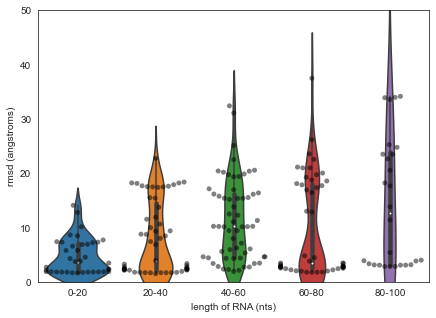

In [47]:
# Bin sizes (nucleotide length range)
jump = 20
lengths = np.array([(i+1) * jump for i in range(100 // jump)])
l = [(np.argwhere(i[-2].shape[0] < lengths)[0][0] + 1) * jump for (k, i) in {**rmsdsTest, **rmsds}.items() if i[0] < 100 and i[-2].shape[0] < 100]
labels = [f'{i-jump}-{i}' for i in l]
plt.figure(figsize=(7,5))

# Violin plot
g = sns.violinplot(x=labels, \
                   y=np.array([i[0] for i in {**rmsdsTest, **rmsds}.values() if i[0] < 100 and i[-2].shape[0] < 100]),
                   order=[f'{i-jump}-{i}' for i in lengths], aspect=1)
g.set_xlabel('length of RNA (nts)')
g.set_ylabel('rmsd (angstroms)')
sns.swarmplot(order=[f'{i-jump}-{i}' for i in lengths], x=labels, y=np.array([i[0] for i in {**rmsdsTest, **rmsds}.values() if i[0] < 100 and i[-2].shape[0] < 100]), color="k", alpha=0.5)
g.set_ylim([0, 50])

# Production script

Input: primary sequence (`seq`) and output directory (`output_dir`)

Output: 3D coordinates of coarse-grained RNA model, which is also saved in PDB file format.

In [11]:
seq = 'AUCGGCGAU'
output_dir = 'output'

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, SpatialDropout2D as Dropout2D, LayerNormalization as LN
from tensorflow.nn import leaky_relu as LR

BATCH = 1

# From EDMNets
class Softplusmh(tf.keras.layers.Layer):
    """
    Matrix softplus function for symmetric input matrices. The resulting matrix is symmetric positive definite.
    """

    def call(self, inputs, **kw):
        eigenvalues, eigenvectors = tf.linalg.eigh(inputs)
        sp_ev = tf.math.softplus(eigenvalues)
        sp_ev_D = tf.linalg.diag(sp_ev)
        eigenvectors_T = tf.linalg.matrix_transpose(eigenvectors)
        spA = eigenvectors @ sp_ev_D @ eigenvectors_T
        return spA, eigenvalues, sp_ev

class L2M(tf.keras.layers.Layer):
    """
    Converts an L matrix (shape n-1 x n-1) to an M matrix (shape n x n) by padding the first column and row with zeros.
    """

    def call(self, inputs, **kw):
        return tf.pad(inputs, [[0, 0], [1, 0], [1, 0]])


class M2D(tf.keras.layers.Layer):
    """
    Converts a Gram matrix `M` to an EDM `D`.
    """

    def call(self, inputs, **kwargs):
        M = inputs
        M_diag = tf.linalg.diag_part(M)
        return tf.expand_dims(M_diag, 1) + tf.expand_dims(M_diag, 2) - 2. * M

# The implementation of Figure 1
class epRNA(tf.keras.Model):
    def __init__(self, hidden_dim=128, kernel_size=3, n_hidden=8, n_EDM=4):
        super(epRNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.reduction = Dense(hidden_dim, kernel_regularizer='l2')
        self.hidden = [(Conv2D(filters=hidden_dim, kernel_size=kernel_size, padding='same', kernel_regularizer='l2')) for i in range(n_hidden)]
        self.LNs = [LN() for i in range(n_hidden)]
        self.toEDM = [(Dense(hidden_dim, kernel_regularizer='l2')) for i in range(n_EDM)]
        self.LNs2 = [LN() for i in range(n_EDM)]
        self.last = Dense(1)
        self.SP = Softplusmh()
        self.l2m = L2M()
        self.m2d = M2D()
    
    # Implement the forward pass of the network
    # Input [BATCH, N, N, C^2]
    def call(self, mat):        
        # Reduce sparsity
        mat = self.reduction(mat) # [BATCH, N, N, hidden_dim]
        mat = LR(mat) # [BATCH, N, N, hidden_dim]
        
        # Convolutions, dimensions remain the same
        prev = mat
        for i, (layer, ln) in enumerate(zip(self.hidden, self.LNs)):
            # Layer normalization
            mat = ln(mat)
            # Hidden layer
            mat = layer(mat)
            # Activation
            mat = LR(mat)
            # Dropout
            mat = Dropout2D(rate=0.2)(mat)
            # Residual connection
            if i % 3 == 1:
                mat = mat + prev
                prev = mat
        
        # Processing to EDM input
        for i, (layer, ln) in enumerate(zip(self.toEDM, self.LNs2)):
            mat = ln(mat)
            mat = layer(mat)
            mat = LR(mat)
            mat = Dropout(rate=0.2)(mat)
        # Residual connection
        mat = mat + prev # [BATCH, N, N, hidden_dim]
        mat = self.last(mat) # [BATCH, N, N, 1]
        mat = tf.squeeze(mat, axis=-1) # [BATCH, N, N]
        mat = 0.25 * (mat[..., :-1, :-1] + mat[..., 1:, :-1] + mat[..., :-1, 1:] + mat[..., 1:, 1:]) # [BATCH, N-1, N-1]
        
        # Algorithm 1 from Hoffmann and Noé
        L = 0.5 * (mat + tf.linalg.matrix_transpose(mat)) # [BATCH, N-1, N-1]
        L, _, ev_L = self.SP(L) # [BATCH, N, N]
        M = self.l2m(L) # Gram matrix
        D = self.m2d(M) # Euclidean distance matrix [BATCH, N, N]
        return D, M


def edm_loss(D, J):
    """
    Loss imposing a soft constraint on EDMness for the input matrix `D`.
    :param D: a hollow symmetric matrix
    :param n_atoms: number of atoms
    :return: loss value
    """
    # D is EDM iff T = -0.5 JDJ is positive semi-definite
    T = -0.5 * tf.matmul(tf.matmul(J, D), J)
    J_ev = tf.linalg.eigvalsh(T)
    return tf.reduce_sum(tf.square(tf.nn.relu(-J_ev)), axis=-1)

def rank_penalty(M, target_rank):
    eigenvalues, _ = tf.linalg.eigh(M)
    n_eigenvalues = tf.shape(eigenvalues)[1]
    undesired_evs, _ = tf.math.top_k(-eigenvalues, k=n_eigenvalues - target_rank, sorted=False,
                                     name="undesired_evs")
    undesired_evs = tf.square(undesired_evs)
    return tf.reduce_sum(undesired_evs, axis=-1)

DIM = 3

Js = {}
for n_atoms in range(6, 150):
    eye = tf.eye(num_rows=n_atoms)
    J = eye - tf.ones(shape=(n_atoms, n_atoms)) / n_atoms
    J = tf.reshape(J, shape=(-1, n_atoms, n_atoms))
    J = J[None, :, :]
    Js[n_atoms] = J
    
import os, numpy as np
model = epRNA()
model.load_weights('trained_models/E128Short/EDRNA')

residueTypes = ['N', 'C', 'I', 'DA', 'U', 'DG', 'DU', 'G', 'A']
oneHot = lambda x: [x == i for i in residueTypes]
def processSeq(seq):
    X = np.array([oneHot(m) for m in seq])
    X = X[None, None, ..., None]
    X = X * np.transpose(X, axes=[0, 2, 1, 4, 3])
    # Flatten last two dimensions
    mat = np.reshape(X, (1, X.shape[1], X.shape[1], -1))
    return model(mat.astype(np.float32))

def kabsch(A, B, axis=0):
    a_mean = tf.reduce_mean(A, axis=axis, keepdims=True)
    b_mean = tf.reduce_mean(B, axis=axis, keepdims=True)
    A_c = A - a_mean
    B_c = B - b_mean
    # Covariance matrix
    H = tf.transpose(A_c) @ B_c
    S, U, V = tf.linalg.svd(H)
    # Rotation matrix
    R = V @ tf.transpose(U)
    Rp = V @ np.diag([1, 1, -1]) @ tf.transpose(U)
    A_aligned = tf.transpose(R @ tf.transpose(A_c))
    A_alignedp = tf.transpose(Rp @ tf.transpose(A_c))
    rmsd = tf.sqrt(tf.reduce_sum((A_aligned - B_c) ** 2) / A.shape[0])
    rmsdp = tf.sqrt(tf.reduce_sum((A_alignedp - B_c) ** 2) / A.shape[0])
    if rmsd < rmsdp:
        return R, rmsd, A_aligned
    else:
        return Rp, rmsdp, A_alignedp
    return R, rmsd, A_aligned

def MDS(D):
    n = tf.shape(D)[-1]
    C = tf.eye(n) - 0.5 / tf.cast(n, tf.float32) * tf.ones_like(D)
    B = -0.5 * C @ tf.square(D) @ C
    e, v = tf.linalg.eigh(B)
    e = tf.sqrt(e[..., None, -1:-4:-1])
    v = v[..., -1:-4:-1]
    return e * v
D, M = processSeq(seq)

Ds = processSeq(seq)[0][0].numpy()
n = len(Ds)
coords = MDS(Ds).numpy()
print(coords)
line = '''ATOM      9  C3'   G A   1      29.309  20.686  72.124  1.00 10.00           C  '''
if not os.path.exists(output_dir):
    os.system(f'mkdir {output_dir}')
with open(f'{output_dir}/out.pdb','w') as f:
    f.write('\n'.join(
                      [line.replace('G', nt).replace('  29.309', f'{x:.3f}'.rjust(8)).replace(\
                          '  20.686', f'{y:.3f}'.rjust(8)).replace('  72.124', f'{z:.3f}'.rjust(8)).replace('A   1', 'A' + f'{index}'.rjust(4)).replace(\
                        '   9', f'{index}'.rjust(4)) for (index, (nt, (x, y, z))) in enumerate(zip(seq, coords))]\
                          ))

[[ 18.332249     1.3491447    0.03129009]
 [  7.7855115   -6.557555    -1.2487589 ]
 [  2.970465    -3.3993056   -0.01902536]
 [  3.105733     2.851742     0.35782066]
 [  2.0704153    4.3446145    1.9273238 ]
 [ -0.42108744   7.45988     -1.0448437 ]
 [ -5.3580303    4.1209097   -2.7607396 ]
 [-10.269694    -1.6979162   -3.3069818 ]
 [-16.954514    -1.5542059    2.6594877 ]]
